In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
vanilla = pd.read_csv("./data/vanilla.csv")
vanilla["algorithm"] = "vanilla"
parfor = pd.read_csv("./data/parfor.csv")
parfor["algorithm"] = "parfor"
tiled = pd.read_csv("./data/tiled.csv")
tiled["algorithm"] = "tiled"
dac_notemp = pd.read_csv("./data/DAC_notemp.csv")
dac_notemp["algorithm"] = "dac_notemp"
dac_temp = pd.read_csv("./data/DAC_temp.csv")
dac_temp["algorithm"] = "dac_temp"
strassens = pd.read_csv("./data/strassens.csv")
strassens["algorithm"] = "strassens"

In [3]:
vanilla_median = vanilla.groupby(["threads", "N", "algorithm"]).median().reset_index()
parfor_median = parfor.groupby(["threads", "N", "algorithm"]).median().reset_index()
tiled_median = tiled.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()
dac_notemp_median = dac_notemp.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()
dac_temp_median = dac_temp.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()
strassens_median = strassens.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()

dfs = [vanilla_median, parfor_median, tiled_median, dac_notemp_median, dac_temp_median, strassens_median]

In [4]:
for df in dfs:
    # df["serial_runtime(ms)"] = df.apply(lambda r:
    #                                     df.query(f"N == {r['N']} and param == {r['param']} and threads == 1")
    #                                     ["runtime(ms)"].iloc[0], axis=1)
    df["serial_runtime(ms)"] = df.apply(lambda r: 
                                        vanilla_median.query(f"N == {r['N']}")["runtime(ms)"].iloc[0], axis=1)
    df["Speedup"] = df["serial_runtime(ms)"] / df["runtime(ms)"]
    df["Efficiency"] = df["Speedup"] / df["threads"]

In [5]:
parfor_median["N"].unique(), parfor_median["threads"].unique()

(array([  64,  128,  256,  512, 1024, 2048]), array([ 1,  2,  4,  8, 12, 16]))

In [6]:
max_time = max(map(lambda df: df["runtime(ms)"].max(), dfs))
max_time

42034.55

In [7]:
all_runs = pd.concat(dfs).reset_index(drop=True)
all_runs.loc[all_runs.groupby(["threads", "N"])["runtime(ms)"].idxmin()]

,threads,N,algorithm,runtime(ms),param,serial_runtime(ms),Speedup,Efficiency
42,1,64,tiled,0.22610,8.0,0.59350,2.624945,2.624945
46,1,128,tiled,1.82000,8.0,4.54775,2.498764,2.498764
50,1,256,tiled,15.12600,8.0,36.95800,2.443343,2.443343
54,1,512,tiled,175.59250,8.0,363.41650,2.069658,2.069658
58,1,1024,tiled,1362.00000,8.0,2767.19000,2.031711,2.031711
418,1,2048,strassens,10844.30000,32.0,30952.95000,2.854306,2.854306
66,2,64,tiled,0.14660,8.0,0.59350,4.048431,2.024216
70,2,128,tiled,0.96055,8.0,4.54775,4.734527,2.367264
74,2,256,tiled,7.79870,8.0,36.95800,4.738995,2.369497
78,2,512,tiled,86.74030,8.0,363.41650,4.189708,2.094854


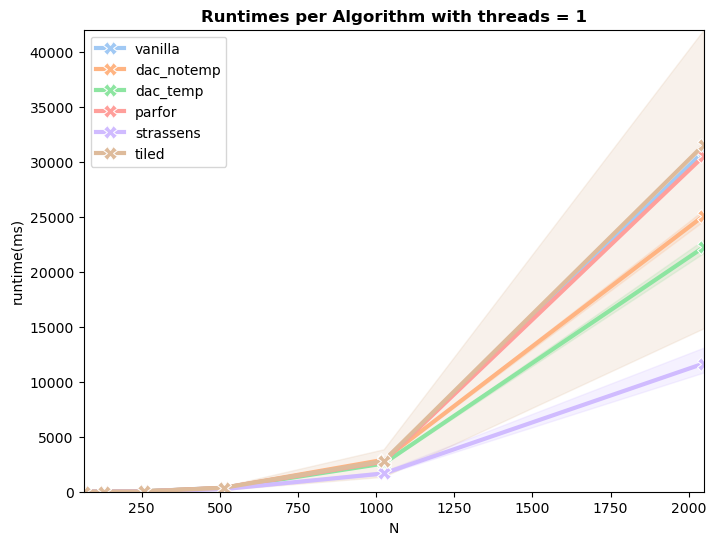

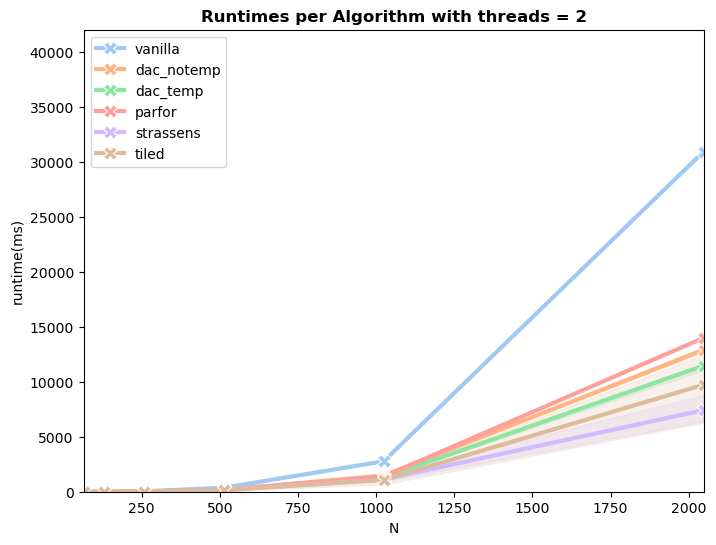

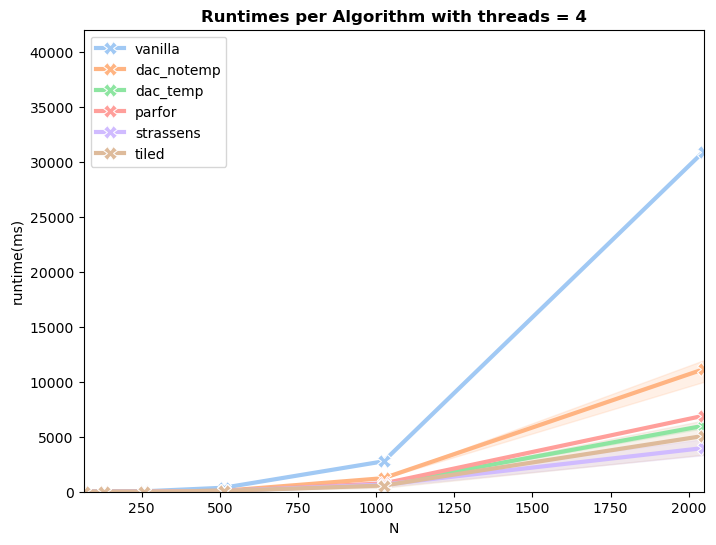

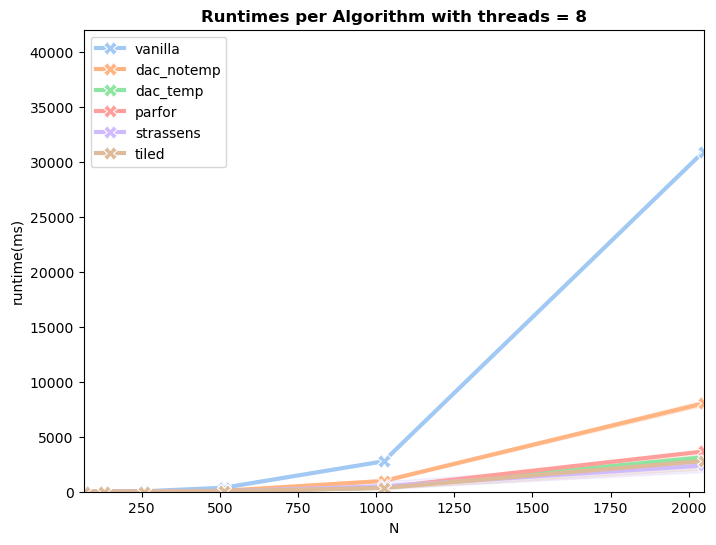

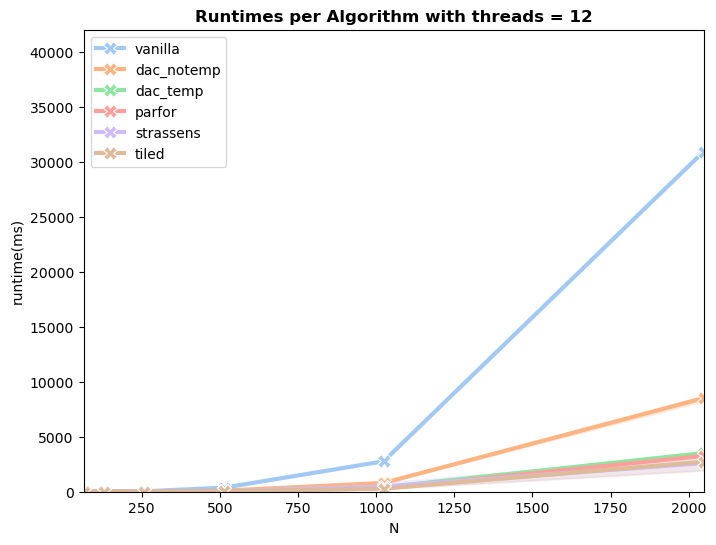

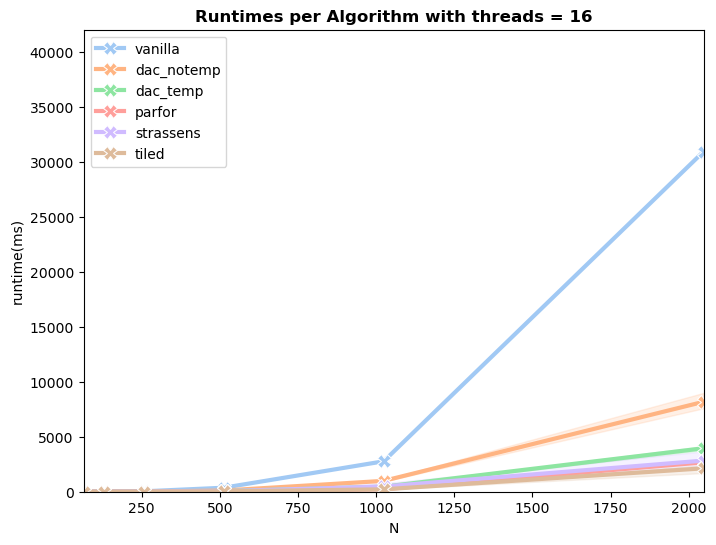

In [8]:
for thr, g1 in all_runs.query("algorithm != 'vanilla'").groupby("threads"):
    colors = sns.color_palette("pastel", 6)
    sns.lineplot(vanilla_median, x="N", y="runtime(ms)", label="vanilla", 
                c=colors[0], linewidth=3, marker="X", markersize=10)
    for i, (alg, g2) in enumerate(g1.groupby("algorithm")):
        sns.lineplot(g2, x="N", y="runtime(ms)", label=alg,
                     c=colors[i+1], errorbar=lambda x: (x.min(), x.max()),
                     linewidth=3, marker="X", markersize=10)
    t = f"Runtimes per Algorithm with threads = {thr}"
    plt.title(t, weight="bold")
    plt.xlim(64, g1["N"].max())
    plt.ylim(0, max_time)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + ".png", transparent=True)
    plt.show()

In [9]:
def plot_runtimes(df, x, y, title):
    colors = sns.color_palette("Spectral", 6)
    t = f"Runtimes of the {title} Algorithm"
    sns.lineplot(df[df["threads"] == 1], x=x, y=y, label="1 thread", c=colors[0])
    for i, threads in enumerate([2, 4, 8, 12, 16]):
        sns.lineplot(df[df["threads"] == threads], x=x, y=y, label=f"{threads} threads", c=colors[i+1],
                     errorbar=lambda x: (x.min(), x.max()), marker="X", markersize=10)
    plt.title(t, weight="bold")
    plt.xlim(64, df[x].max())
    plt.ylim(0, max_time)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + ".png", transparent=True)
    plt.show()


def plot_strong_scaling(df, x, y, title, param_name=None):
    t = f"Strong Scaling of the {title} Algorithm"
    colors = sns.color_palette("pastel", len(df["param"].unique()))
    for p, c in zip(df["param"].unique(), colors):
        sns.lineplot(df[df["param"] == p], x=x, y=y, errorbar=lambda x: (x.min(), x.max()), linewidth=3,
                     label=f"Real {y}" + (f" ({param_name} = {p})" if param_name else ""), 
                     c=c, marker="X", markersize=10)
    if y == "Speedup":
        plt.axline((1, 1), (df[x].max(), df[x].max()), label=f"Ideal {y}", c="black")
    else:
        plt.axline((0, 1), (df[x].max(), 1), label=f"Ideal {y}", c="black")
    plt.title(t, weight="bold")
    plt.xlim(2, df[x].max())
    if y == "Speedup":
        plt.ylim(1, df[x].max())
    else:
        plt.ylim(0, 2)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + f" - {y}.png", transparent=True)
    plt.legend()
    if y == "Speedup":
        plt.grid()
    plt.show()


def plot_weak_scaling(df, x, y, title, param_name=None):
    t = f"Weak Scaling of the {title} Algorithm"
    colors = sns.color_palette("pastel", len(df["param"].unique()))
    for p, c in zip(df["param"].unique(), colors):
        subset = df.query(f"N == 64 * threads and param == {p}")
        sns.lineplot(subset, x=x, y=y, errorbar=lambda x: (x.min(), x.max()), linewidth=3,
                     label=f"Real {y}" + (f" ({param_name} = {p})" if param_name else ""), 
                     c=c, marker="X", markersize=10)
    if y == "Speedup":
        plt.axline((1, 1), (subset[x].max(), subset[x].max()), label=f"Ideal {y}", c="black")
    else:
        plt.axline((0, 1), (subset[x].max(), 1), label=f"Ideal {y}", c="black")
    plt.title(t, weight="bold")
    plt.xlim(2, subset[x].max())
    if y == "Speedup":
        plt.ylim(1, subset[x].max())
    else:
        plt.ylim(0, 2)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + f" - {y}.png", transparent=True)
    plt.legend()
    if y == "Speedup":
        plt.grid()
    plt.show()
    

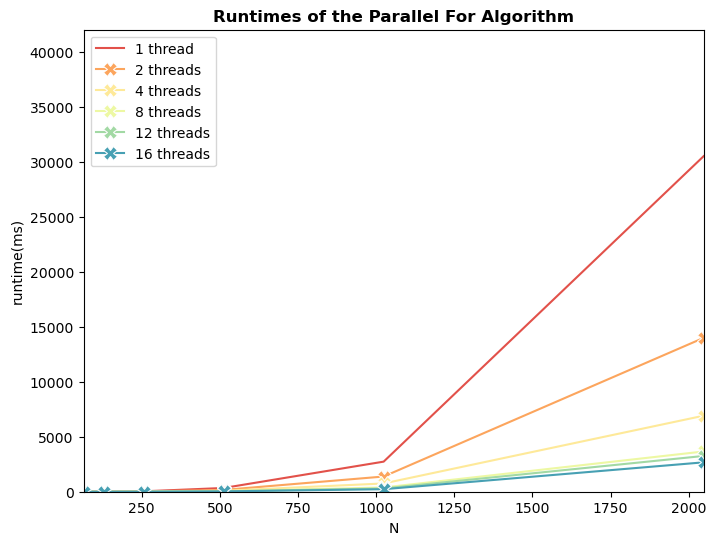

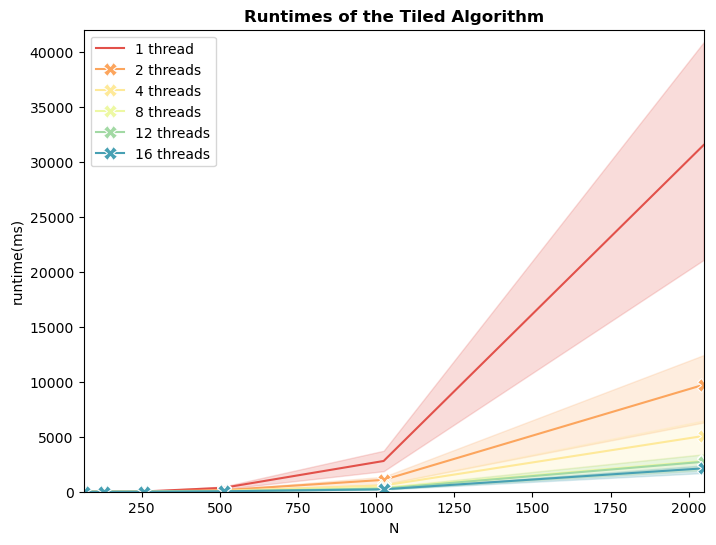

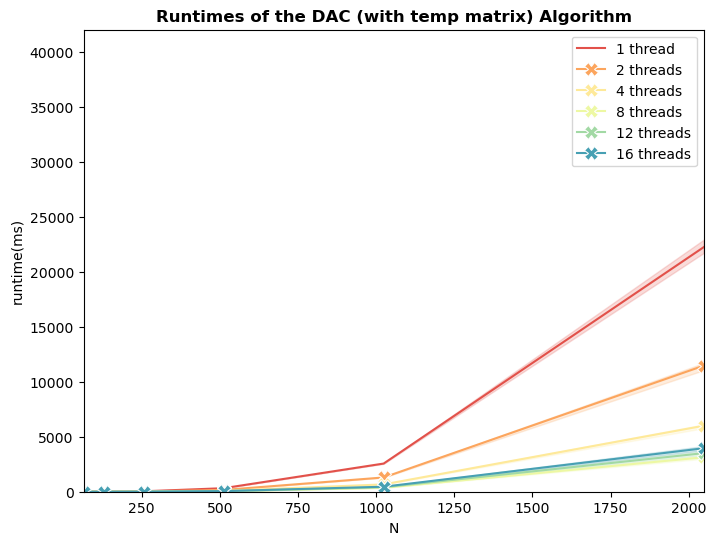

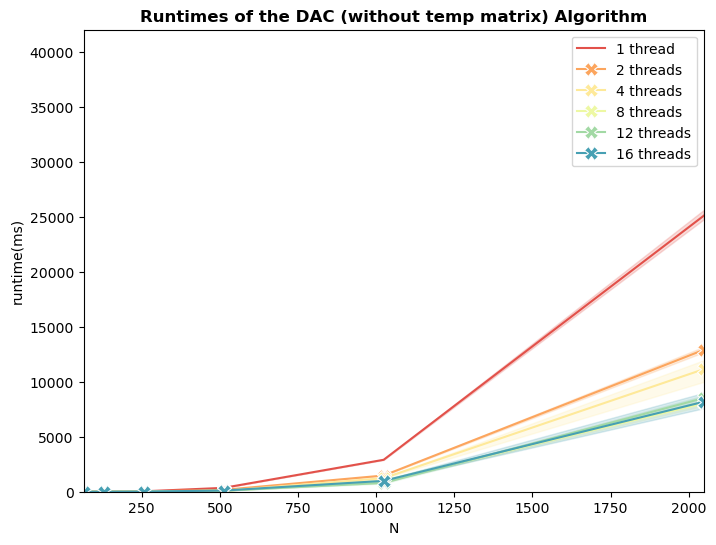

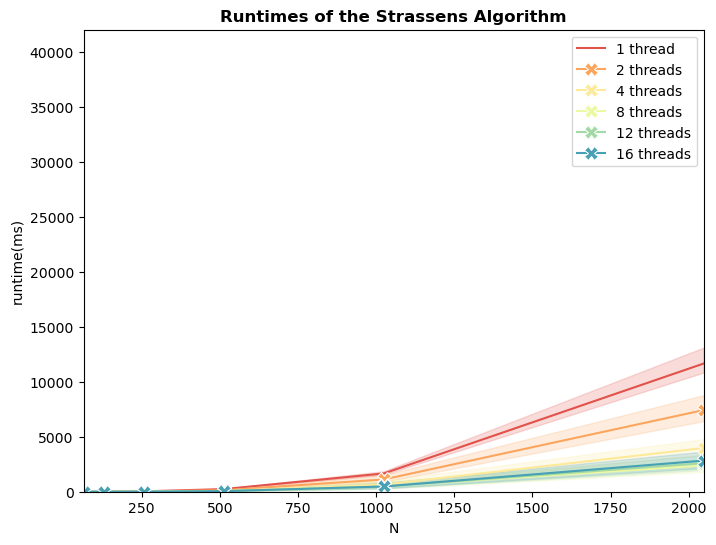

In [10]:
plot_runtimes(parfor_median, "N", "runtime(ms)", "Parallel For")
plot_runtimes(tiled_median, "N", "runtime(ms)", "Tiled")
plot_runtimes(dac_temp_median, "N", "runtime(ms)", "DAC (with temp matrix)")
plot_runtimes(dac_notemp_median, "N", "runtime(ms)", "DAC (without temp matrix)")
plot_runtimes(strassens_median, "N", "runtime(ms)", "Strassens")

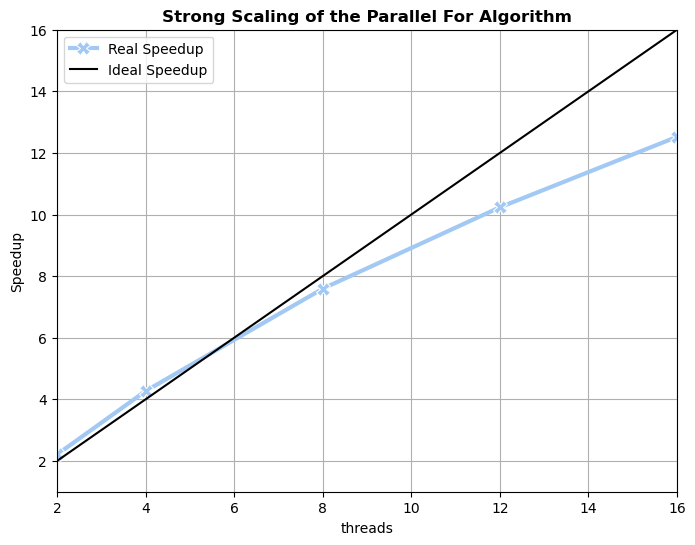

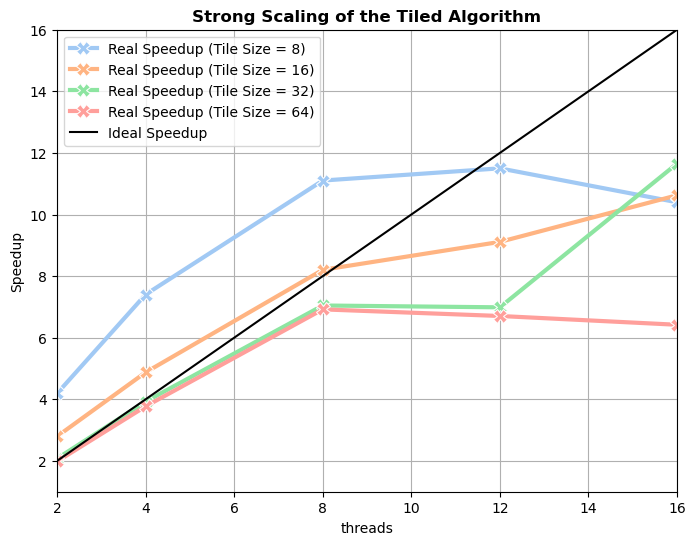

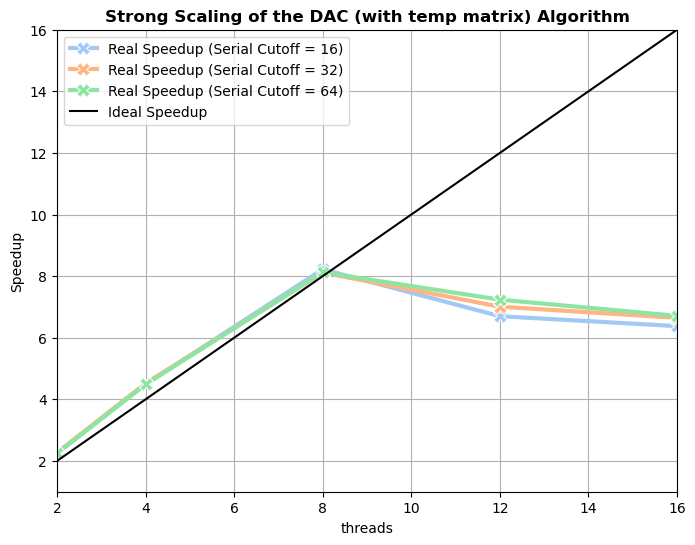

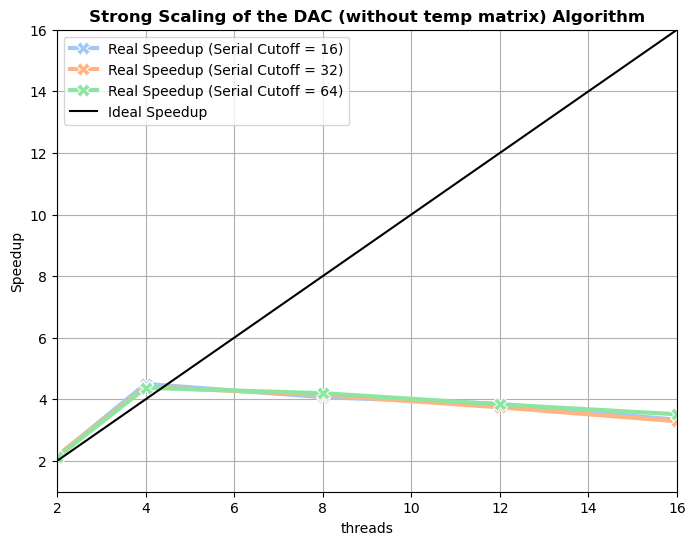

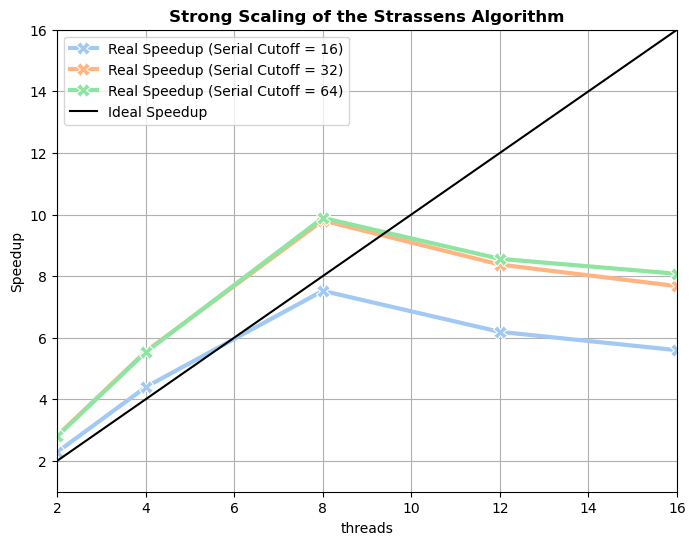

In [11]:
max_N = 512
plot_strong_scaling(parfor_median[parfor_median["N"] == max_N], "threads", "Speedup", "Parallel For")
plot_strong_scaling(tiled_median[tiled_median["N"] == max_N], "threads", "Speedup", "Tiled", "Tile Size")
plot_strong_scaling(dac_temp_median[dac_temp_median["N"] == max_N], "threads", "Speedup", "DAC (with temp matrix)", "Serial Cutoff")
plot_strong_scaling(dac_notemp_median[dac_notemp_median["N"] == max_N], "threads", "Speedup", "DAC (without temp matrix)", "Serial Cutoff")
plot_strong_scaling(strassens_median[strassens_median["N"] == max_N], "threads", "Speedup", "Strassens", "Serial Cutoff")

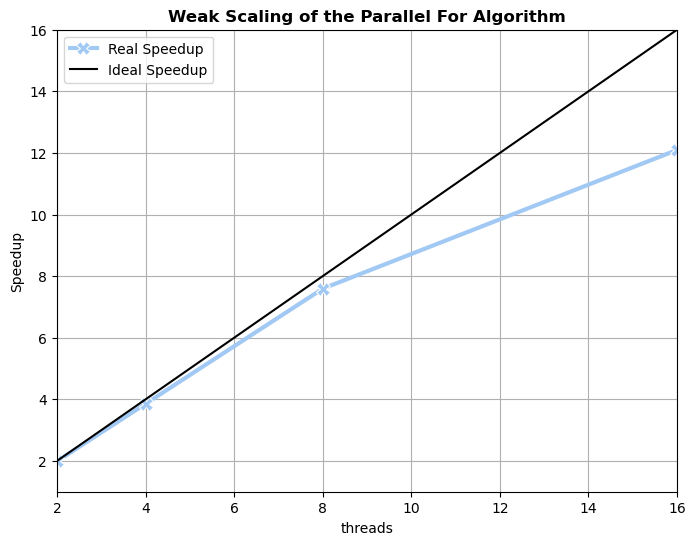

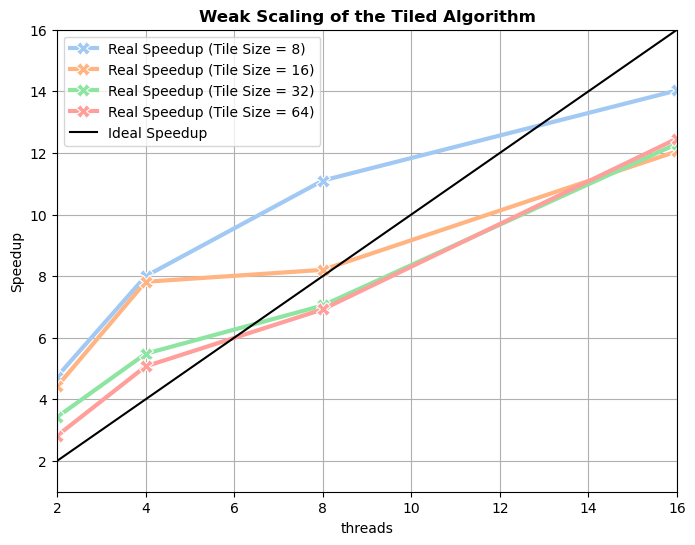

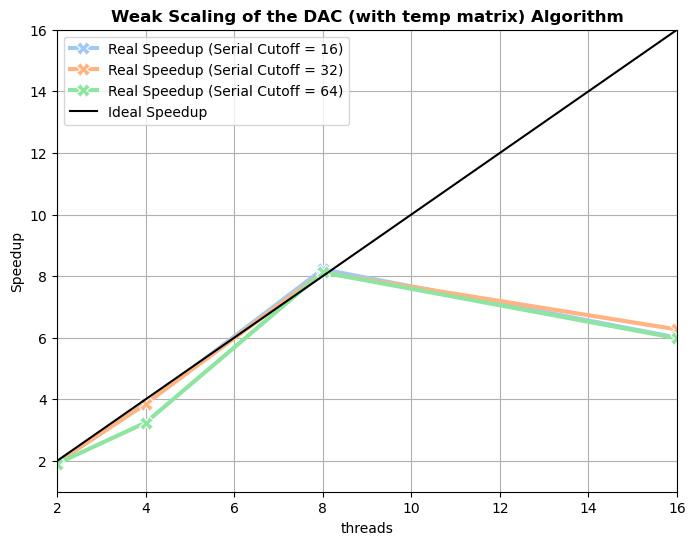

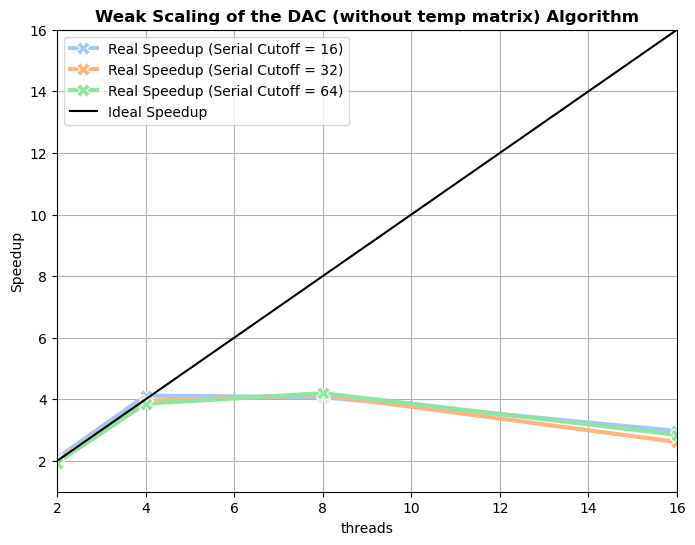

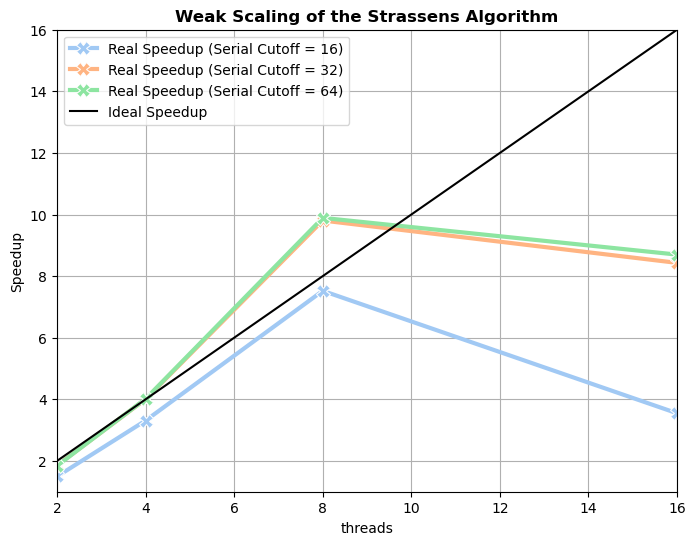

In [12]:
plot_weak_scaling(parfor_median, "threads", "Speedup", "Parallel For")
plot_weak_scaling(tiled_median, "threads", "Speedup", "Tiled", "Tile Size")
plot_weak_scaling(dac_temp_median, "threads", "Speedup", "DAC (with temp matrix)", "Serial Cutoff")
plot_weak_scaling(dac_notemp_median, "threads", "Speedup", "DAC (without temp matrix)", "Serial Cutoff")
plot_weak_scaling(strassens_median, "threads", "Speedup", "Strassens", "Serial Cutoff")

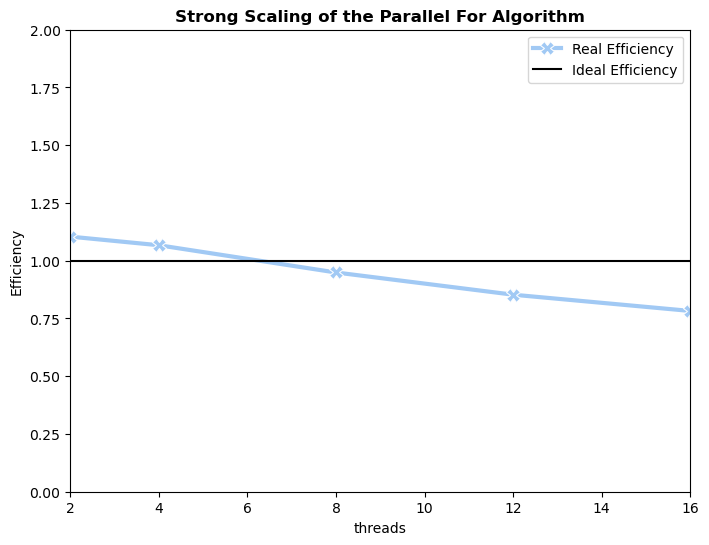

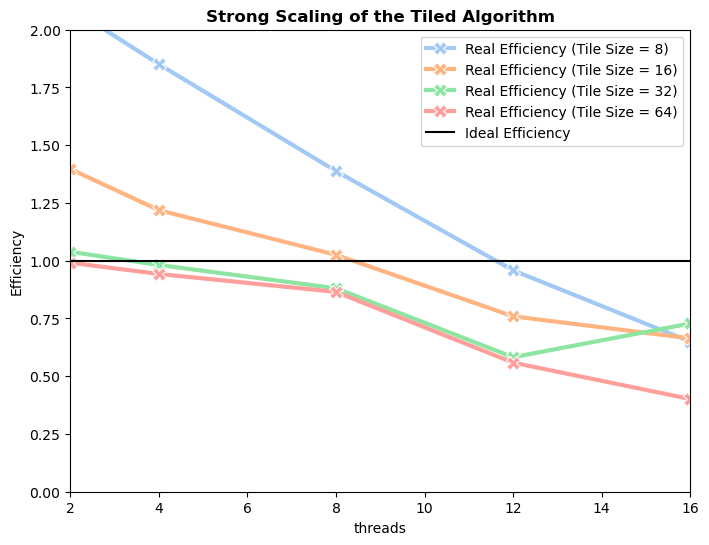

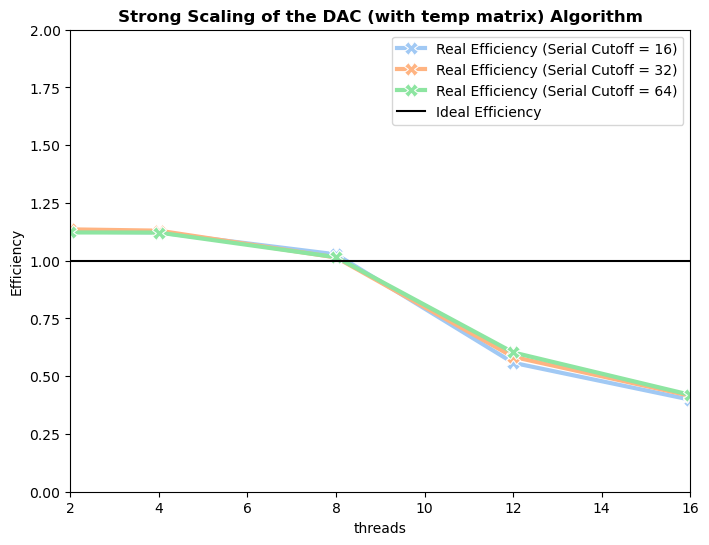

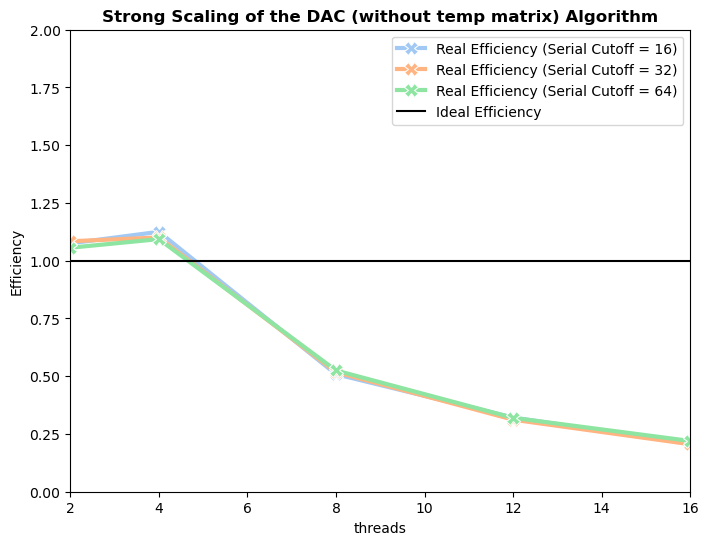

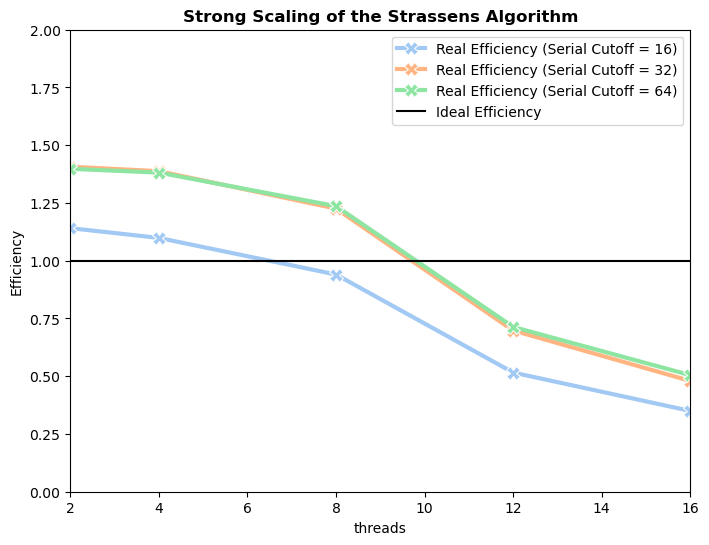

In [13]:
max_N = 512
plot_strong_scaling(parfor_median[parfor_median["N"] == max_N], "threads", "Efficiency", "Parallel For")
plot_strong_scaling(tiled_median[tiled_median["N"] == max_N], "threads", "Efficiency", "Tiled", "Tile Size")
plot_strong_scaling(dac_temp_median[dac_temp_median["N"] == max_N], "threads", "Efficiency", "DAC (with temp matrix)", "Serial Cutoff")
plot_strong_scaling(dac_notemp_median[dac_notemp_median["N"] == max_N], "threads", "Efficiency", "DAC (without temp matrix)", "Serial Cutoff")
plot_strong_scaling(strassens_median[strassens_median["N"] == max_N], "threads", "Efficiency", "Strassens", "Serial Cutoff")

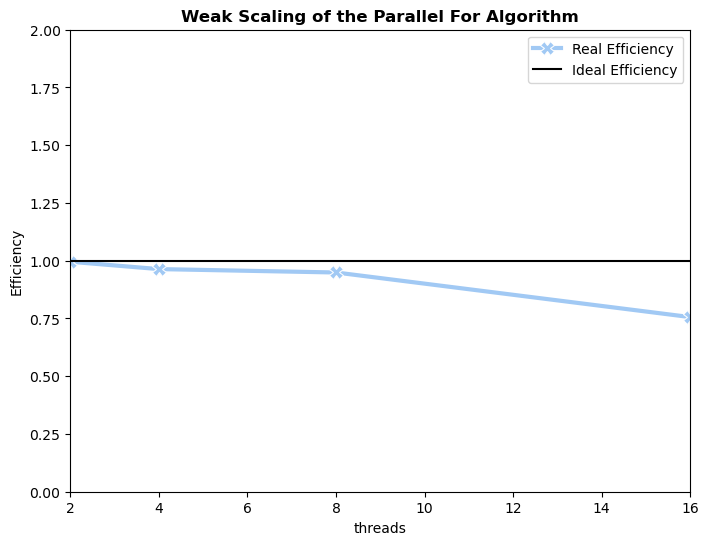

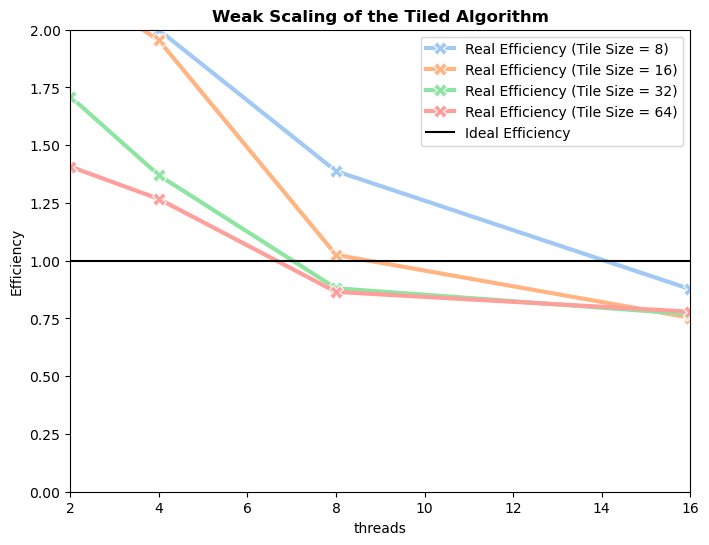

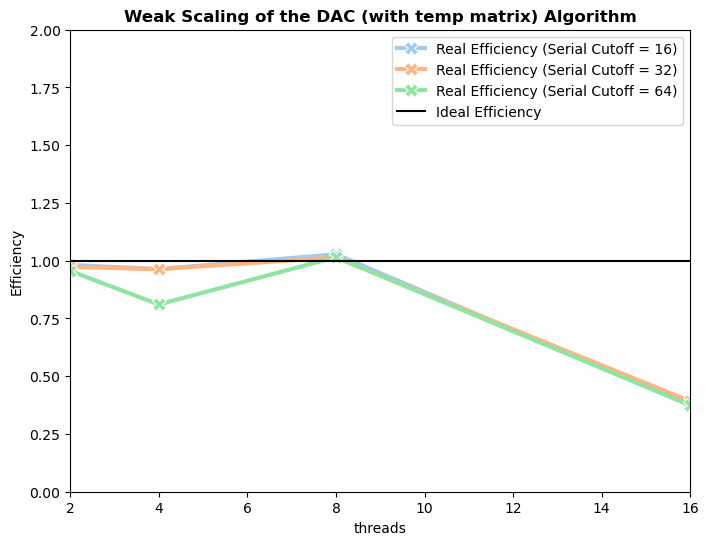

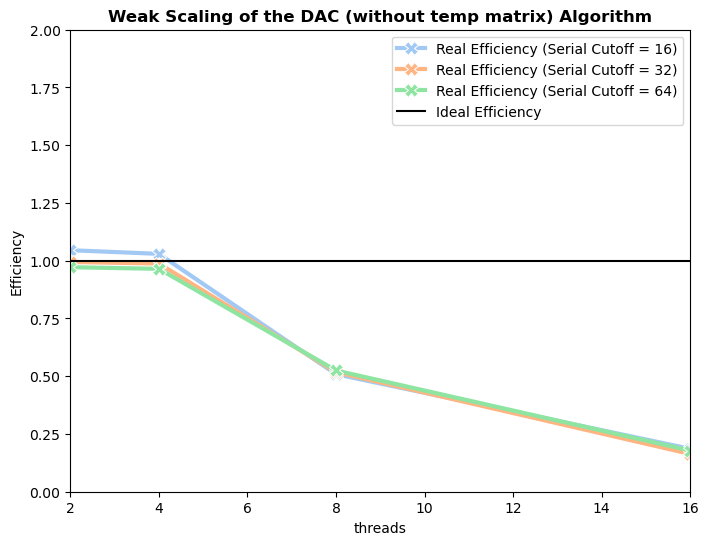

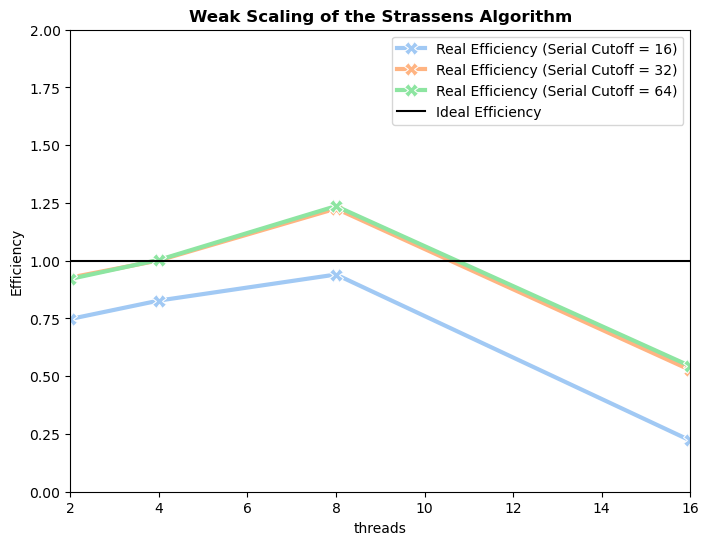

In [14]:
plot_weak_scaling(parfor_median, "threads", "Efficiency", "Parallel For")
plot_weak_scaling(tiled_median, "threads", "Efficiency", "Tiled", "Tile Size")
plot_weak_scaling(dac_temp_median, "threads", "Efficiency", "DAC (with temp matrix)", "Serial Cutoff")
plot_weak_scaling(dac_notemp_median, "threads", "Efficiency", "DAC (without temp matrix)", "Serial Cutoff")
plot_weak_scaling(strassens_median, "threads", "Efficiency", "Strassens", "Serial Cutoff")